# import + functions

In [1]:
## Import

import os
import scipy.io
import numpy as np
import os, importlib
import matplotlib.pyplot as plt
import statistics
import scipy.stats
import matplotlib.patches as mpatches
import tkinter as tk
import pandas as pd
import pickle
from open_ephys.analysis import Session
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from moviepy.editor import *
import glob
import cv2


## Functions

def diff(data):
    diff = []
    for i in range(1,len(data)):
        diff = diff + [data[i] - data[i-1]]
    return(diff)

def create_spike_time_vectors(spike_times,clusters):
    spiketimevectors = []
    for i in np.unique(clusters):
        spiketimevectors = spiketimevectors + [spike_times[np.where(clusters==i)[0]]]
    return spiketimevectors

def SaveFig(file_name,figure_dir):
    if os.path.isfile(figure_dir + file_name ):
        os.remove(figure_dir + file_name)  
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name)
    plt.close()
    

def Reformat_PokeEphysTS(PokeIn_EphysTS):
    P1_PokeIn_EphysTS = np.array([])
    P2_PokeIn_EphysTS = np.array([])
    for ind, item in enumerate(PokeIn_EphysTS):
        if ind > 0:
            P1_PokeIn_EphysTS = np.append(P1_PokeIn_EphysTS,[PokeIn_EphysTS[ind-1]])
            
            if item == 'NaN':
                P2_PokeIn_EphysTS = np.append(P2_PokeIn_EphysTS,[np.nan])
            else:
                P2_PokeIn_EphysTS =  np.append(P2_PokeIn_EphysTS,[item])
    return np.array(P1_PokeIn_EphysTS),P2_PokeIn_EphysTS



## new version for new open ephys tools 
def align_open_ephys_processors(main_processor_tuple, aux_processor_tuples,raw_data_directory, sync_channel=1):

    session_data = Session(str(raw_data_directory))
    if len(session_data.recordnodes) != 1:
        raise ValueError("should be exactly one record node.")
    if len(session_data.recordnodes[0].recordings) != 1:
        raise ValueError("Should be exactly one recording.")
    for rn, recordnode in enumerate(session_data.recordnodes):
        for r, recording in enumerate(recordnode.recordings):
            # Synch
            recording.add_sync_line(
                sync_channel,
                main_processor_tuple[0],
                main_processor_tuple[1],
                main=True,
            )
            for aux_processor in aux_processor_tuples:
                recording.add_sync_line(
                    sync_channel,
                    aux_processor[0],
                    aux_processor[1],
                    main=False,
                )
            print('this should be zero:')
            print(rn)
        
    return recording


def sequence_contains_sequence(haystack_seq, needle_seq, string):
    start_index = []
    for i in range(0, len(haystack_seq) - len(needle_seq) + 1):
        if needle_seq == haystack_seq[i:i+len(needle_seq)]:
            start_index = start_index + [i]
            print(string + ' barcode found')
    return start_index

def find_first_poke_times(trial_id,ports, poke_in_array):

    first_poke_index = []
    count = 1

    for index,item in enumerate(trial_id):
        if item == count:
            if ports[index] == 2:
                count = count + 1
                first_poke_index = first_poke_index + [index]
            
    return poke_in_array[np.array(first_poke_index)]

def align_firstpoke_camera_timestamps(trial_id,Trial_start_ts,All_Port_references_sorted):
    counter = 0
    trial_ts_aligned = []
    for index,item in enumerate(trial_id):
        if All_Port_references_sorted[index] == 2.0:
            if item > counter:
                counter = counter + 1
                #getting an error 05/01/22 -> I think if the next trial started (TTL went high) but no poke was recorded then there wont be a poke timestamp so account for this: 
                if not len(Trial_start_ts) == counter - 1:
                    trial_ts_aligned = trial_ts_aligned + [Trial_start_ts[counter-1]]
                else:
                    trial_ts_aligned = trial_ts_aligned + ['NaN']
            else:
                trial_ts_aligned = trial_ts_aligned + ['NaN']
        else:
            trial_ts_aligned = trial_ts_aligned + ['NaN']
    return trial_ts_aligned

def align_trial_start_end_timestamps(trial_id,Trial_start_ts):
    trial_ts_aligned = []
    counter = 1
    for index, item in enumerate(trial_id):
        if counter ==  item:
            trial_ts_aligned = trial_ts_aligned + [Trial_start_ts[counter-1]]
        else:
            counter = counter + 1
            trial_ts_aligned = trial_ts_aligned + [Trial_start_ts[counter-1]]
    
    return trial_ts_aligned
            

def clock_find_first_poke_times(trial_id,ports, poke_in_array,trial_seqs):

    first_poke_index = []
    count = 1

    for index,item in enumerate(trial_id):
        if item == count:
            if ports[index] == trial_seqs[index][0]:
                count = count + 1
                first_poke_index = first_poke_index + [index]
            
    return poke_in_array[np.array(first_poke_index)]

def clock_align_firstpoke_camera_timestamps(trial_id,Trial_start_ts,All_Port_references_sorted,trial_seqs):
    counter = 0
    trial_ts_aligned = []
    for index,item in enumerate(trial_id):
        if All_Port_references_sorted[index] == trial_seqs[index][0]:
            if item > counter:
                counter = counter + 1
                #getting an error 05/01/22 -> I think if the next trial started (TTL went high) but no poke was recorded then there wont be a poke timestamp so account for this: 
                if not len(Trial_start_ts) == counter - 1:
                    trial_ts_aligned = trial_ts_aligned + [Trial_start_ts[counter-1]]
                else:
                    trial_ts_aligned = trial_ts_aligned + ['NaN']
            else:
                trial_ts_aligned = trial_ts_aligned + ['NaN']
        else:
            trial_ts_aligned = trial_ts_aligned + ['NaN']
    return trial_ts_aligned

def AlignToTriggersAndFIndEphysTimestamps(Port_intimes,trial_id,first_poke_times,trial_start,TrialStart_EphysTime,FirstPoke_EphysTime):

    new_TS = []
    for index, trial in enumerate(trial_id):
        if np.isnan(Port_intimes[index]):
            new_TS = new_TS + [np.nan]
        else:

            current_poke_event_time = Port_intimes[index]

            # find ech relevant timestamps
            CurrentTrial_startTS = trial_start[trial-1]
            First_pokeTS = first_poke_times[trial-1]

            # last trial has no next trial start
            if trial == trial_id[-1]:
                NextTrial_startTS = 9999999999999
            else:
                NextTrial_startTS = np.unique(trial_start)[trial]

            # find the ts current poke event is closest to
            trialstart_diff =  abs(CurrentTrial_startTS - current_poke_event_time)

            EphysTS = TrialStart_EphysTime[trial-1]
            current_dist = current_poke_event_time - CurrentTrial_startTS 
            distance = EphysTS + current_dist

            new_TS = new_TS + [distance]
            
    return(new_TS)

def Determine_Transition_Times_and_Types(All_PortIn_Times_sorted ,All_PortOut_Times_sorted, All_Port_references_sorted):
    out_in= []
    in_in = []
    transition_type = []
    out_in_transition_reference = []
    in_in_transition_reference = []
    for index,port in enumerate(All_Port_references_sorted):
        if index > 0:
            out_in = out_in + [All_PortIn_Times_sorted[index] - All_PortOut_Times_sorted[index-1] ]
            out_in_transition_reference = out_in_transition_reference + [All_PortOut_Times_sorted[index-1]]

            in_in = in_in + [All_PortIn_Times_sorted[index] - All_PortIn_Times_sorted[index-1] ]
            in_in_transition_reference = in_in_transition_reference + [All_PortIn_Times_sorted[index-1]]

            transition_type = transition_type + [int(str(All_Port_references_sorted[index-1]) + str(port))]

    return (np.array(out_in),np.array(in_in) ,np.array(transition_type),out_in_transition_reference,in_in_transition_reference)

def Determine_transition_matrix(prev_port,current_port):
    Transition = (prev_port * 10) + current_port
    return Transition

def Start_End_port_id(Transition_types,start_end_arg):
    output = []
    for item in Transition_types:
        String = str(item)
        output = output + [int(String[start_end_arg])]
    return output

def determine_RepeatPort_events(start_port_ids,end_port_ids):
    Port_repeat = []
    for index, item in enumerate(start_port_ids):
        if item == end_port_ids[index]:
            Port_repeat = Port_repeat + [0]
        else: 
            Port_repeat = Port_repeat + [1]
    return Port_repeat    

def filter_transitons_by_latency(Transition_times, Upper_Filter):
    Filtered_transitions = []
    for item in Transition_times:
        if item < Upper_Filter:
            Filtered_transitions = Filtered_transitions + [1]
        else:
            Filtered_transitions = Filtered_transitions + [0]
    return Filtered_transitions

def find_files(filename, search_path):
    result = []

    #Walking top-down from the root
    for root, dir, files in os.walk(search_path):
        if filename in files:
            result.append(os.path.join(root, filename))

    return result

def find_folder_path(parent_folder, target_folder):
    for root, dirs, files in os.walk(parent_folder):
        if target_folder in dirs:
            return os.path.join(root, target_folder)
        # If the target folder is not found
    return (print('not found'))

def test_timestamps_(Trial_start_ts,Trial_start_Camera_Ts):
    working = False
    try:
        trial_start_difference = (np.diff(Trial_start_ts) - np.diff(Trial_start_Camera_Ts)[0:-1])
        working = True

    except:
        print('broken - being fixed')
        tester = False
        while tester == False:
            Trial_start_Camera_Ts,tester = fix_missing_triggers(Trial_start_ts,Trial_start_Camera_Ts)
            print('fixed')
        print('all fixed')
    try:
        trial_start_difference = (np.diff(Trial_start_ts) - np.diff(Trial_start_Camera_Ts)[0:-1])
        working = True
        print('working')
    except:
        print('fail')

    for item in (trial_start_difference):
        if abs(item) > 1:
            raise NameError('Test not passed, Timestamps dont line up!')

    print('test passed!')
    
    Trial_start_Camera_Ts= Trial_start_Camera_Ts
    
    return Trial_start_Camera_Ts

def fix_missing_triggers(Trial_start_ts,Trial_start_Camera_Ts):

    fixed_trial_strart_ts= []
    for index,item in enumerate(np.diff(Trial_start_ts)):
        if abs(item - np.diff(Trial_start_Camera_Ts)[index]) > 1:
#             missing_trigger = Trial_start_Camera_Ts[index]+np.diff(Trial_start_ts)[index]
            missing_trigger = np.nan
            fixed_trial_strart_ts = np.insert(Trial_start_Camera_Ts,index+1,[missing_trigger])
            print(index)
            break
    
    try:
        trial_start_difference = (np.diff(Trial_start_ts) - np.diff(fixed_trial_strart_ts)[0:-1])
        for item in (trial_start_difference):
            if abs(item) > 1:
                tester = False
            else:
                tester = True
    except:
        tester = False

    return fixed_trial_strart_ts, tester


def align_to_start_ts(trials,fixed_cam_ts):
    Camera_timestamps = []
    Camera_time = []
    for trial in trials :
        Camera_timestamps.append(fixed_cam_ts[trial-1])
        Camera_time.append(fixed_cam_ts[trial-1])
    return Camera_timestamps,Camera_time

## alignment: 
def align_allpokes_to_cam_trialstart(Trials,trial_start_bpod_ts,PokeIn_Time,Fixed_back_cam_tstart_ts):

    cam_poke_times = []
    for index,trial in enumerate(Trials):
        bpod_trial_start = trial_start_bpod_ts[trial-1]
        poke_time = PokeIn_Time[index]
        diff = poke_time - bpod_trial_start
        cam_poke_times = cam_poke_times + [(Fixed_back_cam_tstart_ts[trial-1]) + diff]

    return cam_poke_times

def Determine_Transition_Times_and_Types(All_PortIn_Times_sorted ,All_PortOut_Times_sorted, All_Port_references_sorted):
    out_in= []
    in_in = []
    transition_type = []
    out_in_transition_reference = []
    in_in_transition_reference = []
    for index,port in enumerate(All_Port_references_sorted):
        if index > 0:
            out_in = out_in + [All_PortIn_Times_sorted[index] - All_PortOut_Times_sorted[index-1] ]
            out_in_transition_reference = out_in_transition_reference + [All_PortOut_Times_sorted[index-1]]

            in_in = in_in + [All_PortIn_Times_sorted[index] - All_PortIn_Times_sorted[index-1] ]
            in_in_transition_reference = in_in_transition_reference + [All_PortIn_Times_sorted[index-1]]

            transition_type = transition_type + [int(str(All_Port_references_sorted[index-1]) + str(port))]

    return (np.array(out_in),np.array(in_in) ,np.array(transition_type),out_in_transition_reference,in_in_transition_reference)


def Start_End_port_id(Transition_types,start_end_arg):
    output = []
    for item in Transition_types:
        String = str(item)
        output = output + [int(String[start_end_arg])]
    return output

def determine_RepeatPort_events(start_port_ids,end_port_ids):
    Port_repeat = []
    for index, item in enumerate(start_port_ids):
        if item == end_port_ids[index]:
            Port_repeat = Port_repeat + [0]
        else: 
            Port_repeat = Port_repeat + [1]
    return Port_repeat    

def filter_transitons_by_latency(Transition_times, Upper_Filter):
    Filtered_transitions = []
    for item in Transition_times:
        if item < Upper_Filter:
            Filtered_transitions = Filtered_transitions + [1]
        else:
            Filtered_transitions = Filtered_transitions + [0]
    return Filtered_transitions

def load_H5_bodypart_ports(tracking_path):

    back_file = pd.read_hdf(tracking_path)

    # drag data out of the df
    scorer = back_file.columns.tolist()[0][0]
    
    # drag data out of the df
    scorer = back_file.columns.tolist()[0][0]

    # list all the columns in the dataframe 
    columns = back_file[scorer].columns.get_level_values(0).unique()

    bodypart= [[]]*len(columns)
    for index, column in enumerate(columns):
        bodypart[index] =back_file[scorer][column]

    for item in bodypart:
        clean_and_interpolate(item,0.9)
        
    return bodypart


def list_files(directory, extension):
    return (f for f in os.listdir(directory) if f.endswith('.' + extension))

def files(folderpath, pattern="*"):
    """
        returns all files folders in a given folder matching a pattern
    """
    return [f for f in folderpath.glob(pattern) if f.is_file()]

def clean_and_interpolate(head_centre,threshold):
    bad_confidence_inds = np.where(head_centre.likelihood.values<threshold)[0]
    newx = head_centre.x.values
    newx[bad_confidence_inds] = 0
    newy = head_centre.y.values
    newy[bad_confidence_inds] = 0

    start_value_cleanup(newx)
    interped_x = interp_0_coords(newx)

    start_value_cleanup(newy)
    interped_y = interp_0_coords(newy)
    
    head_centre['interped_x'] = interped_x
    head_centre['interped_y'] = interped_y
    
def start_value_cleanup(coords):
    # This is for when the starting value of the coords == 0; interpolation will not work on these coords until the first 0 
    #is changed. The 0 value is changed to the first non-zero value in the coords lists
    for index, value in enumerate(coords):
        working = 0
        if value > 0:
            start_value = value
            start_index = index
            working = 1
            break
    if working == 1:
        for x in range(start_index):
            coords[x] = start_value
            
def interp_0_coords(coords_list):
    #coords_list is one if the outputs of the get_x_y_data = a list of co-ordinate points
    for index, value in enumerate(coords_list):
        if value == 0:
            if coords_list[index-1] > 0:
                value_before = coords_list[index-1]
                interp_start_index = index-1
                #print('interp_start_index: ', interp_start_index)
                #print('interp_start_value: ', value_before)
                #print('')

        if index < len(coords_list)-1:
            if value ==0:
                if coords_list[index+1] > 0:
                    interp_end_index = index+1
                    value_after = coords_list[index+1]
                    #print('interp_end_index: ', interp_end_index)
                    #print('interp_end_value: ', value_after)
                    #print('')

                    #now code to interpolate over the values
                    try:
                        interp_diff_index = interp_end_index - interp_start_index
                    except UnboundLocalError:
#                         print('the first value in list is 0, use the function start_value_cleanup to fix')
                        break
                    #print('interp_diff_index is:', interp_diff_index)

                    new_values = np.linspace(value_before, value_after, interp_diff_index)
                    #print(new_values)

                    interp_index = interp_start_index+1
                    for x in range(interp_diff_index):
                        #print('interp_index is:', interp_index)
                        #print('new_value should be:', new_values[x])
                        coords_list[interp_index] = new_values[x]
                        interp_index +=1
        if index == len(coords_list)-1:
            if value ==0:
                for x in range(30):
                    coords_list[index-x] = coords_list[index-30]
                    #print('')
#     print('function exiting')
    return(coords_list)


def extract_frames_by_number(input_file, output_file, start_frame, end_frame):
    """
    Extracts frames from a video file based on frame numbers and saves as a new video.

    :param input_file: Path to the input video file.
    :param output_file: Path to save the output video file.
    :param start_frame: The starting frame number (inclusive).
    :param end_frame: The ending frame number (inclusive).
    """
    # Open the input video
    cap = cv2.VideoCapture(input_file)
    if not cap.isOpened():
        print("Error: Cannot open video file.")
        return

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for output file

    # Open the VideoWriter
    out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

    # Read and process frames
    frame_number = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Write frames in the specified range
        if start_frame <= frame_number <= end_frame:
            out.write(frame)

        # Stop if end frame is reached
        if frame_number > end_frame:
            break

        frame_number += 1

    # Release resources
    cap.release()
    out.release()
    print(f"Extracted video saved to {output_file}")
    
    
def align_to_start_ts(trials,fixed_cam_ts):
    Camera_timestamps = []
    Camera_time = []
    for trial in trials :
        Camera_time.append(fixed_cam_ts[trial-1])
    return Camera_time

## alignment: 
def align_allpokes_to_cam_trialstart(Trials,trial_start_bpod_ts,PokeIn_Time,Fixed_back_cam_tstart_ts):

    cam_poke_times = []
    for index,trial in enumerate(Trials):
        bpod_trial_start = trial_start_bpod_ts[trial-1]
        poke_time = PokeIn_Time[index]
        diff = poke_time - bpod_trial_start
        cam_poke_times += [Fixed_back_cam_tstart_ts[trial-1] + diff]

    return cam_poke_times

def find_closest_cameraframe_index(behav_cam_ts, back_aligned_time):
    closest_inds = []
    for time in back_aligned_time:
        # find the ind where the camera timestamp is closest to the poke in time
        closest_inds += [behav_cam_ts.index[0] + np.argmin(np.abs(behav_cam_ts['Time Stamps'].values - time))]
    return closest_inds



In [78]:
base_recording_paths

['Z:\\projects\\sequence_squad\\revision_data\\lars_recordings\\ephys\\\\ap5\\ap5R_2024-11-20_09-00-27_saline',
 'Z:\\projects\\sequence_squad\\revision_data\\lars_recordings\\ephys\\\\ap5\\ap5R_2024-11-21_09-21-32_ap5_ctb647',
 'Z:\\projects\\sequence_squad\\revision_data\\lars_recordings\\ephys\\\\ap5\\ap5R_2024-11-25_09-41-07',
 'Z:\\projects\\sequence_squad\\revision_data\\lars_recordings\\ephys\\\\ap5\\ap5R_2024-11-26_09-29-29_ap5_488',
 'Z:\\projects\\sequence_squad\\revision_data\\lars_recordings\\ephys\\\\dual_strd_hpc\\seq006_2024-11-25_09-37-51',
 'Z:\\projects\\sequence_squad\\revision_data\\lars_recordings\\ephys\\\\dual_strd_hpc\\seq006_2024-11-26_09-26-05',
 'Z:\\projects\\sequence_squad\\revision_data\\lars_recordings\\ephys\\\\dual_strd_hpc\\seq006_2024-11-27_09-46-17',
 'Z:\\projects\\sequence_squad\\revision_data\\lars_recordings\\ephys\\\\dual_strd_hpc\\seq006_2024-11-28_09-48-35',
 'Z:\\projects\\sequence_squad\\revision_data\\lars_recordings\\ephys\\\\dual_strd_hpc

# Choose data to process:

In [79]:
probe = 'probeA'
index = 0

#sample rate:
Fs = 30000.0

## gather all raw ephys paths
path_ = r"Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\\"
base_recording_paths = []
for q in os.listdir(path_):
    if not 'other_sessions' in q:
        folder = os.path.join(path_,q)
        for q in os.listdir(folder):
            base_recording_paths+=[os.path.join(folder,q)]
            

# gather the corespoding organised paths for each raw dat file 
organised_path = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
full_organised_paths = []
for i in range(len(base_recording_paths)):
    mouse_id = base_recording_paths[i].split('\\')[-1].split('_')[0]
    date_ = base_recording_paths[i].split('\\')[-1].split('_')[1]
    #reverse the date
    date_ = '-'.join(date_.split('-')[::-1])
    
    organised_path_animal = os.path.join(organised_path,mouse_id+'_implant1')

    for recording in os.listdir(organised_path_animal):
        if date_ in recording:
            full_organised_paths += [os.path.join(organised_path_animal,recording)]
            break


for index in range(len(base_recording_paths)):
    print(index)
    index = 16
       
    # set important paths 
    raw_data_directory = base_recording_paths[index]
    print(raw_data_directory)
    OE_processor_path = find_folder_path(raw_data_directory, "continuous") 
    Behav_data_path = full_organised_paths[index]+ r'//behav_sync/2_task/Preprocessed//'

    Processed_Ephys_data_path = full_organised_paths[index]+ r'/ephys//' + probe + r'/kilosort4_output/sorter_output//'
    
    organised_ephys_path = full_organised_paths[index]+ r'/ephys//'

    if probe in os.listdir(full_organised_paths[index]+ r'/ephys//'):
        if 'unit_info.txt' in os.listdir(full_organised_paths[index]+ r'/ephys//' + probe):
            print('All good! Data is kilosorted')
            
            print(os.listdir(full_organised_paths[index]+ r'/ephys//'))
            print(raw_data_directory)
            print(OE_processor_path)
            print(Behav_data_path)
            print(Processed_Ephys_data_path)
            break
        else:
            print('data not yet kilosorted, skip!')
    else:
        print('data not yet kilosorted, skip!')
        
        
### add to this... if its already been run then also skip...
    

print(index)



0
Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\\learning\ap5R_2024-11-16_12-22-37
All good! Data is kilosorted
['probeA']
Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\\learning\ap5R_2024-11-16_12-22-37
Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\\learning\ap5R_2024-11-16_12-22-37\Record Node 105\experiment1\recording1\continuous
Z:\projects\sequence_squad\revision_data\organised_data\animals\\ap5R_implant1\recording1_16-11-2024//behav_sync/2_task/Preprocessed//
Z:\projects\sequence_squad\revision_data\organised_data\animals\\ap5R_implant1\recording1_16-11-2024/ephys//probeA/kilosort4_output/sorter_output//
16


'Z:\\projects\\sequence_squad\\revision_data\\lars_recordings\\ephys\\\\learning\\ap5R_2024-11-16_12-22-37'

In [80]:
# to do...
# decide which units to keep and throw... 
## this script also needs to deal with the probe B stuff...

# choose which units to keep based on LFP spectral power? 

In [4]:
 ### load in spectral power data and use this to make a decision... 
 
 ## then make spikes files from this
 
 ### then in the rest of this doc make the alignment stuff... 
 
 
 
 
# #### Make spike time vectors: 

# # load in spike data and curation file:
# spike_times = np.load(Processed_Ephys_data_path + 'spike_times.npy')
# spike_times = (np.concatenate(spike_times))/Fs
# clusters = np.load(Processed_Ephys_data_path + 'spike_clusters.npy')

# # Manual_Score = pd.read_csv(Processed_Ephys_data_path + 'cluster_group.tsv', sep='\t')

# Manual_Score = pd.read_csv(Processed_Ephys_data_path + 'cluster_KSLabel.tsv', sep='\t')

# Sort spike data into vectors that can be rasters. ie. single clusters and all spike times in ephys time 

# create spike time vectors for all clusters, adjus for start time offset:
# spiketimevectors = create_spike_time_vectors(spike_times,clusters)

# pull out curation scores for each cluster

# Mscore = list(Manual_Score.loc[:,'group'])
# clusterid = list(Manual_Score.loc[:,'cluster_id'])

# Mscore = list(Manual_Score.loc[:,'KSLabel'])
# clusterid = list(Manual_Score.loc[:,'cluster_id'])


# Sort these by good/bad manual clustering scores
# filter spike vectors by manual curation scores:
# CuratedeSpikeTimeVectors = []
# CuratedSpikeClusterIds= []
# for index,ids in enumerate(clusterid):
#     if Mscore[index] == 'good':
#         ind = np.where(np.unique(clusters) == ids)[0][0]
#         CuratedeSpikeTimeVectors = CuratedeSpikeTimeVectors + [spiketimevectors[ind]]
#         CuratedSpikeClusterIds = CuratedSpikeClusterIds + [ids]
        
# print('Total curated clusters = ' + str(len(CuratedeSpikeTimeVectors)))

## Save out curated spike time clusters:

# if not os.path.isdir(output_path):
#     os.makedirs(output_path)
    
# filename = 'Curated_Cluster-Ids'
# with open(output_path  + '/' + filename, 'wb') as fp:
#     pickle.dump(CuratedSpikeClusterIds,fp)
    
# filename = 'Curated_Cluster-SpikeTimes'
# with open(output_path + '/' + filename, 'wb') as fp:
#     pickle.dump(CuratedeSpikeTimeVectors,fp)

# Load in raw ephys data and compute gloabl timestamps 

In [82]:
import re
count = 0
for processor in os.listdir(OE_processor_path):
    if count == 0:
        main1 = int(re.findall(r'\d+', processor)[0])
        main1_2 = processor.split('.')[-1]
    elif count == 1:
        main2 = int(re.findall(r'\d+', processor)[0])
        main2_2 = processor.split('.')[-1]
    elif count == 2:
        main3 = int(re.findall(r'\d+', processor)[0])
        main3_2 = processor.split('.')[-1]
    count +=1 

main_processor_tuple=(main1, main1_2)

aux_processor_tuples=((main2,main2_2),(main3,main3_2))


############ DONT RUN MORE THAN ONCE! ITS SO SLOW! ######################

### LOAD in data: this could take a few minutes

# check to see if global object alreayd exists and fi it does... load premade one instead of doing it the slow way 
if not 'global-timstamps_event-df.pkl' in os.listdir(organised_ephys_path):
    
    recording = align_open_ephys_processors(main_processor_tuple,aux_processor_tuples,raw_data_directory)
    recording.compute_global_timestamps()
    
    ## Save this out:
    print('saving...')
    if not os.path.isdir(organised_ephys_path):
        os.makedirs(organised_ephys_path)
    save_path = organised_ephys_path + f"global-timstamps_event-df.pkl"
    recording.events.to_pickle(save_path)
    
    ## Extract timestamp data:
    events_df= recording.events
    
else:
    print('already computed, loading...')
    events_df = pd.read_pickle(organised_ephys_path + 'global-timstamps_event-df.pkl')
    
############ DONT RUN MORE THAN ONCE! ITS SO SLOW! ######################

# i believe line 2 is the 2nd ttl line which carries the Bpod TTLs to the nidaq
Bpod_NIDAQ_TTLS = events_df[events_df.line == 2]

### sort out offset:
ProbeB_exists = False
sync_messages_path = find_files("sync_messages.txt",raw_data_directory)[0]
sync = open(sync_messages_path, 'r')
lines = sync.readlines()
for line in lines:
    if 'Neuropix-PXI' in line:
        if 'ProbeA' in line:
            print(line)
            start_time_offset_A = int(re.findall(r'\d+', line)[-1]) / Fs
            print(start_time_offset_A)
            
        if 'ProbeB' in line:
            print(line)
            start_time_offset_B = int(re.findall(r'\d+', line)[-1]) / Fs
            print(start_time_offset_B)
            ProbeB_exists = True



this should be zero:
0
Processor ID: 106, Stream Name: ProbeA-AP, Line: 1 (main sync line))
  First event sample number: 1824543
  Last event sample number: 420058024
  Total sync events: 13942
  Sample rate: 30000.0
Processor ID: 106, Stream Name: ProbeA-LFP, Line: 1 (aux sync line))
  First event sample number: 152045
  Last event sample number: 35004835
  Total sync events: 13942
  Scale factor: 12.000000028692108
  Actual sample rate: 2499.9999940224775
Processor ID: 102, Stream Name: PXIe-6341, Line: 1 (aux sync line))
  First event sample number: 1829552
  Last event sample number: 420103162
  Total sync events: 13942
  Scale factor: 0.9999040604067754
  Actual sample rate: 30002.8784639554
saving...
Start Time for Neuropix-PXI (106) - ProbeA-AP @ 30000 Hz: 1795500

59.85
Start Time for Neuropix-PXI (106) - ProbeA-LFP @ 2500 Hz: 149625

4.9875


# find the start of each behavioural epoch (sleep, task, sleep)

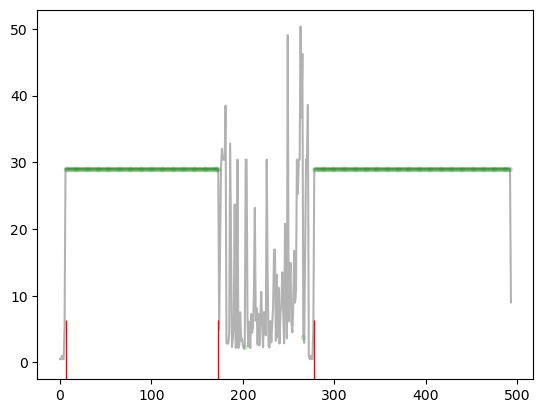

In [83]:
## find barcode indicies: 

# Behaviour_barcode = np.array([0.05, 1.  , 0.05, 0.5 , 0.05, 1.  , 0.05, 0.5 , 0.05, 0.5 , 0.05]) #LSLSSS (last gap cant be seen as no pulse after it...)
# Clock_barcode = np.array([0.05, 1.  , 0.05, 0.5 , 0.05, 1.  , 0.05, 0.5 , 0.05, 1.0 , 0.05]) # LSLSLS
# presleep_barcode = np.array([0.05, 0.5  , 0.05, 0.5 , 0.05, 1.  , 0.05, 0.5 , 0.05, 0.5 , 0.05]) # SSLSSS
# postsleep_barcode = np.array([0.05, 1.  , 0.05, 0.5 , 0.05, 0.5  , 0.05, 0.5 , 0.05, 0.5 , 0.05]) # LSSSSS


# behaviour_barcode_index = sequence_contains_sequence(list(np.round(np.diff(Bpod_NIDAQ_TTLS['global_timestamp']),2)),list(Behaviour_barcode), 'behaviour')
# presleep_barcode_index = sequence_contains_sequence(list(np.round(np.diff(Bpod_NIDAQ_TTLS['global_timestamp']),2)),list(presleep_barcode), 'presleep')
# if len(presleep_barcode_index)>0:
#     presleep_barcode_index = presleep_barcode_index[0]
# postsleep_barcode_index = behaviour_barcode_index[-1]


### barcodes dont seem to be working... not always there...so instead I need to just work out the point when the first camera ts ends

## split into 3 sperates epochs based on triggers
# find trigger onset times
trigger_onset_times = Bpod_NIDAQ_TTLS[Bpod_NIDAQ_TTLS.state == 0]['global_timestamp']

sleep_trigger_inds = np.where((np.diff(trigger_onset_times) > 28.5) & (np.diff(trigger_onset_times) < 31.5))[0]

plt.plot(np.diff(Bpod_NIDAQ_TTLS['global_timestamp'])[1::2], color = 'k', alpha = 0.3)
plt.plot(np.array(sleep_trigger_inds),np.diff(Bpod_NIDAQ_TTLS['global_timestamp'])[1::2][sleep_trigger_inds],'o',alpha = 0.1, color = 'green',markersize = 3)

consecutive_chunks = []
start = None
for i in range(len(sleep_trigger_inds) - 1):
    if sleep_trigger_inds[i + 1] - sleep_trigger_inds[i] == 1:
        if start is None:
            start = sleep_trigger_inds[i]
    else:
        if start is not None:
            end = sleep_trigger_inds[i]
            consecutive_chunks.append((start*2, end*2))
            start = None
if start is not None:
    # *2 because the original array was the diff of the TTL on and off periods and this is just TTL onsets
    consecutive_chunks.append((start*2, sleep_trigger_inds[-1]*2))
    
plt.plot(consecutive_chunks[0][-1]/2,0,'|',markersize = 60, color = 'red')
plt.plot(consecutive_chunks[0][0]/2,0,'|',markersize = 60, color = 'red')
plt.plot(consecutive_chunks[-1][0]/2,0,'|',markersize = 60, color = 'red')


behaviour_barcode_index = consecutive_chunks[0][-1]
presleep_barcode_index = consecutive_chunks[0][0]
postsleep_barcode_index = consecutive_chunks[-1][0]

# load behaviour and check alignment

In [84]:
# load in behavioural data           
Full_Behav_data_path = list(os.walk(Behav_data_path))[-1][0]  
print(Full_Behav_data_path)
poke_data =  pd.read_csv(Full_Behav_data_path + "/PreProcessed_RawPokeData.csv") 

first_poke_times = find_first_poke_times((poke_data['Trial_id']),list(poke_data['Port']), np.array(poke_data['PokeIn_Time']))
all_timestamps = sorted(list(first_poke_times) + list(np.unique(poke_data['Trial_Start'])))

Z:\projects\sequence_squad\revision_data\organised_data\animals\\ap5R_implant1\recording1_16-11-2024//behav_sync/2_task/Preprocessed//00_20241116_135315_Sat


(-0.1, 0.1)

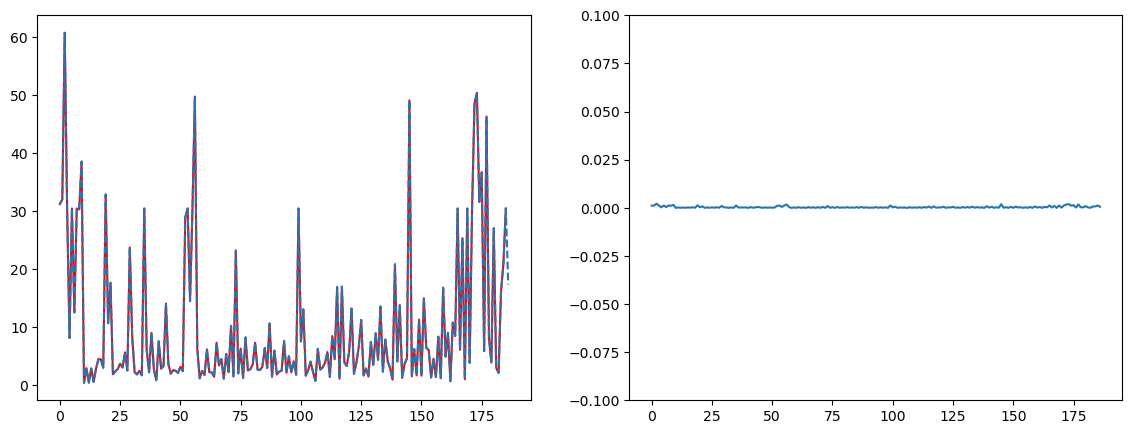

In [85]:
## plot the timestamps (difffernces) to see if they overlay perfectly 

## adjust as needed 
manual_offset = 7

NIDAQ_ts_diff = np.diff(Bpod_NIDAQ_TTLS['global_timestamp'][behaviour_barcode_index+manual_offset:postsleep_barcode_index])
behaviour_ts_diff = np.diff(all_timestamps)


fig, [ax,ax1] = plt.subplots(1, 2, figsize=(14, 5))
ax.plot(NIDAQ_ts_diff[1:len(behaviour_ts_diff)], color = 'red') ## 1:: because the behaviour starts from diff between trial and first poke while ephys starts from barcode/start point end to trial start 
ax.plot(behaviour_ts_diff,'--')
# ax.set_xlim([0, 120])

## plot the difference between the two to see if there is misalingment between the two timestamp sets: 
plt.plot(NIDAQ_ts_diff[1:len(all_timestamps)] - behaviour_ts_diff)
plt.ylim([-0.1, 0.1])


# Align ephys timestamps and behaviour 

start end diffs
for ephys ts:      1793.5040487747237
for behav ts:      1793.439


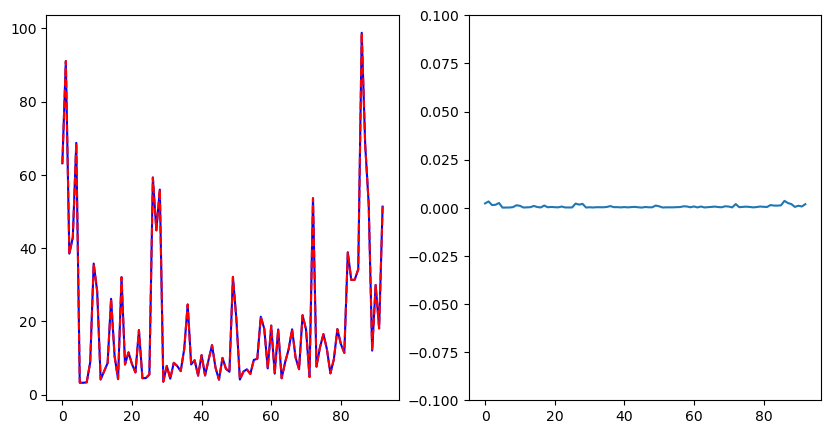

In [93]:
#### align timestamps to behaviour

behav_NIDAQ_events = Bpod_NIDAQ_TTLS[behaviour_barcode_index+manual_offset:postsleep_barcode_index]
all_NIDAQ_TS = behav_NIDAQ_events['global_timestamp'].values

all_states = np.array(behav_NIDAQ_events['state'])
up_ticks_inds = np.where(all_states == 1)
down_ticks_inds = np.where(all_states == 0)

trial_start_TS = np.unique(poke_data['Trial_Start'])
first_poke_TS = np.array(sorted(list(first_poke_times)))

## up ticks - trials start - alignment
aligned_trial_starts_ephys_TS = all_NIDAQ_TS[up_ticks_inds][0:len(trial_start_TS)]


fig, [ax,ax1] = plt.subplots(1, 2, figsize=(10, 5))
ax.plot(np.diff(aligned_trial_starts_ephys_TS), color = 'blue')
ax.plot(np.diff(trial_start_TS), '--',color = 'red')
# plt.xlim([380, 415])
# plt.xlim([60, 100])

ax1.plot(np.diff(aligned_trial_starts_ephys_TS)-np.diff(trial_start_TS))
ax1.set_ylim([-0.1, 0.1])

print('start end diffs')
print('for ephys ts:      '+ str(aligned_trial_starts_ephys_TS[-1] - aligned_trial_starts_ephys_TS[0]))
print('for behav ts:      ' + str(trial_start_TS[-1] -  trial_start_TS[0])) 

(-0.1, 0.1)

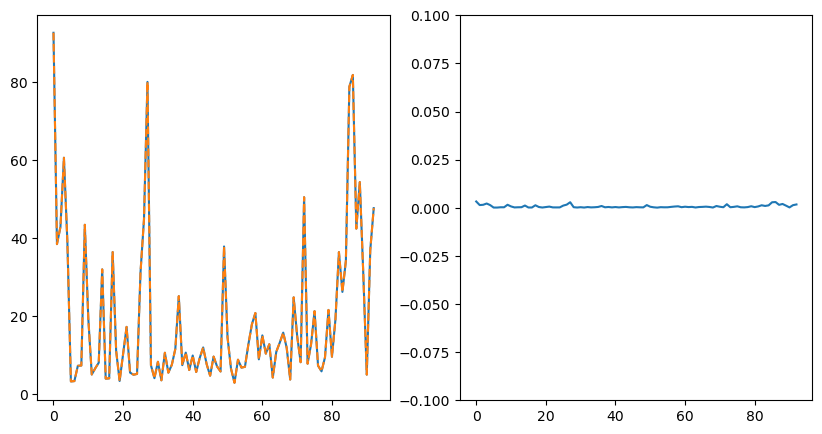

In [94]:
## up ticks - first poke - alignment
fig, [ax,ax1] = plt.subplots(1, 2, figsize=(10, 5))

aligned_first_poke_ephys_TS = all_NIDAQ_TS[down_ticks_inds][1:len(first_poke_TS)+1]

ax.plot(np.diff(aligned_first_poke_ephys_TS))
ax.plot(np.diff(first_poke_TS),'--')
# plt.xlim([380, 415])
# plt.xlim([0, 40])

ax1.plot(np.diff(aligned_first_poke_ephys_TS)-np.diff(first_poke_TS))
ax1.set_ylim([-0.1, 0.1])

# aligne all poke in and out events to nearest ephys trigger

In [95]:
PokeIn_Times = list(poke_data['PokeIn_Time'])
PokeOut_Times = list(poke_data['PokeOut_Time'])
                               
trial_start = list(poke_data['Trial_Start'])
trial_id = list(poke_data['Trial_id'])
                               
PokeInTimes_Ephys_TS = AlignToTriggersAndFIndEphysTimestamps(PokeIn_Times,trial_id,first_poke_TS,trial_start_TS,aligned_trial_starts_ephys_TS,aligned_first_poke_ephys_TS)
PokeOutTimes_Ephys_TS = AlignToTriggersAndFIndEphysTimestamps(PokeOut_Times,trial_id,first_poke_TS,trial_start_TS,aligned_trial_starts_ephys_TS,aligned_first_poke_ephys_TS)

In [96]:
## align to and add to dataframe and then save this out: 

df_aligned_firstpoke_ephys_ts = align_firstpoke_camera_timestamps(list(poke_data['Trial_id']), aligned_first_poke_ephys_TS - start_time_offset_A ,list(poke_data['Port']))
df_aligned_trialstart_ephys_ts = align_trial_start_end_timestamps(list(poke_data['Trial_id']),aligned_trial_starts_ephys_TS)

poke_data['TrialStart_EphysTime'] = np.array(df_aligned_trialstart_ephys_ts) - start_time_offset_A
poke_data['FirstPoke_EphysTime'] = df_aligned_firstpoke_ephys_ts

## acount for offset 
PokeIN_EphysTime = np.array(PokeInTimes_Ephys_TS) - start_time_offset_A
PokeOUT_EphysTime = np.array(PokeOutTimes_Ephys_TS[0:-1]) - start_time_offset_A  

## hack if there is a NaN at the end:
PokeOUT_EphysTime = np.append(np.array(PokeOutTimes_Ephys_TS[0:-1]) - start_time_offset_A,'NaN')
poke_data['PokeIN_EphysTime'] = PokeIN_EphysTime 
poke_data['PokeOUT_EphysTime'] = PokeOUT_EphysTime

# poke_data.to_csv(output_path +'/TaskPokeData_camera_ephys_aligned.csv')

# if ProbeB_exists:
    
#     df_aligned_firstpoke_ephys_ts = align_firstpoke_camera_timestamps(list(poke_data['Trial_id']), aligned_first_poke_ephys_TS - start_time_offset_A ,list(poke_data['Port']))
#     df_aligned_trialstart_ephys_ts = align_trial_start_end_timestamps(list(poke_data['Trial_id']),aligned_trial_starts_ephys_TS)

#     poke_data['TrialStart_EphysTime'] = np.array(df_aligned_trialstart_ephys_ts) - start_time_offset_A
#     poke_data['FirstPoke_EphysTime'] = df_aligned_firstpoke_ephys_ts

#     ## acount for offset 
#     PokeIN_EphysTime = np.array(PokeInTimes_Ephys_TS) - start_time_offset_A
#     PokeOUT_EphysTime = np.array(PokeOutTimes_Ephys_TS[0:-1]) - start_time_offset_A  

#     ## hack if there is a NaN at the end:
#     PokeOUT_EphysTime = np.append(np.array(PokeOutTimes_Ephys_TS[0:-1]) - start_time_offset_A,'NaN')
#     poke_data['PokeIN_EphysTime'] = PokeIN_EphysTime 
#     poke_data['PokeOUT_EphysTime'] = PokeOUT_EphysTime

# start_time_offset_B

Make transition dataframe

In [97]:
Port_intimes = list(poke_data['PokeIn_Time'])
Port_outtimes = list(poke_data['PokeOut_Time'])
Ports = list(poke_data['Port'])

#Determine Transition times and types for all events 
out_in_Transition_times, in_in_Transition_times, Transition_types, out_in_transition_reference,in_in_transition_reference = Determine_Transition_Times_and_Types(Port_intimes,Port_outtimes,Ports)

#Split transtion types into first and last ports: 
start_port_ids = Start_End_port_id(Transition_types,0)
end_port_ids = Start_End_port_id(Transition_types,1)

#Align start and end port time
End_Port_in_time = Port_intimes[1::]
Start_Port_in_time = Port_intimes[0:-1]
End_Port_out_time = Port_outtimes[1::]
Start_Port_out_time = Port_outtimes[0:-1]

#Find Port repeat events (double pokes)
Non_Port_repeat = determine_RepeatPort_events(start_port_ids,end_port_ids)

#Determine which transitions are good: less than 1.5s
out_in_Filtered_transitions = filter_transitons_by_latency(out_in_Transition_times, 2)
in_in_Filtered_transitions = filter_transitons_by_latency(in_in_Transition_times, 2)

In [98]:
# make dataframe:
Transition_df = pd.DataFrame(
    {'Trial_id' : poke_data['Trial_id'][0:-1],
    'Transition_type' : Transition_types,
     'Start_Port':start_port_ids, 
     'End_Port':end_port_ids,
     'Start_Poke_in_time': Start_Port_in_time,
     'Start_Poke_out_time': Start_Port_out_time,
     'End_Poke_in_time': End_Port_in_time,
     'End_Poke_out_time': End_Port_out_time,
     'out_in_Latency' : out_in_Transition_times,
     'in_in_Latency': in_in_Transition_times,
     '2s_Time_Filter_out_in': out_in_Filtered_transitions,
     '2s_Time_Filter_in_in': in_in_Filtered_transitions,
     'Port 2,3,4,5 LED intensities': poke_data['Port 2,3,4,5 LED intensities'][0:-1],
     'Port 1,2,3,4 RewardAmount':poke_data['Port 1,2,3,4 RewardAmount'][0:-1],
     'Repeat_Filter':Non_Port_repeat,
     'P1_IN_Ephys_TS': PokeIN_EphysTime[0:-1],
     'P1_OUT_Ephys_TS': PokeOUT_EphysTime[0:-1],
     'P2_IN_Ephys_TS': PokeIN_EphysTime[1::],
     'P2_OUT_Ephys_TS': PokeOUT_EphysTime[1::]})
    
# #Save Data
# Transition_df.to_csv(output_path +'/TaskTransitionData_camera_ephys_aligned.csv')

# now align the cameras

load in camera ts files

In [100]:
from pathlib import Path

cam_path = '\\'.join(list(Path(organised_ephys_path).parts[0:-1])) + r'\video\videos\\'

# find csv file 
csv_files = [f for f in os.listdir(cam_path) if f.endswith('.csv')]

for csv_file in csv_files:
    if 'BACK' in csv_file:
        print(csv_file)
        cam_ts = pd.read_csv(cam_path + csv_file)
        break




BACK_camera_timestamp_df_AP5_2_R_16-11-2024.csv


# align task period

blue x should be at uptick - bottom
red should be a downtick - top


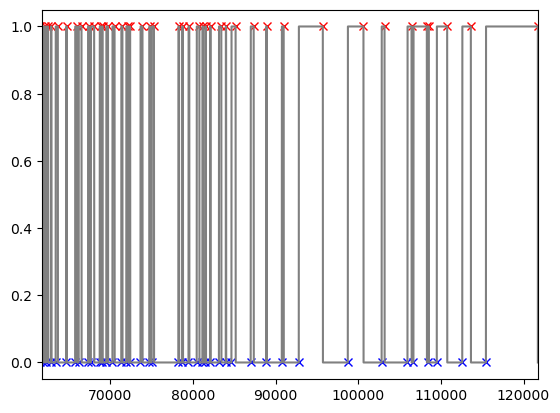

In [101]:
behav_cam_ts = cam_ts[cam_ts.epoch == 'task']

# find camera triggers: 

Camera_trig_states = behav_cam_ts['Trigger State'].values

where_ttl_changes = list(np.where(np.roll(Camera_trig_states,1)!=Camera_trig_states)[0])
if where_ttl_changes[0] == 0:
    where_ttl_changes = where_ttl_changes[1::]

## check this is correct:
plt.plot(np.array(where_ttl_changes[1::2]),np.ones(len(np.array(where_ttl_changes[1::2]))),'x', color = 'red')
plt.plot(np.array(where_ttl_changes[0::2]),np.zeros(len(np.array(where_ttl_changes[0::2]))),'x',color = 'blue')
plt.plot(behav_cam_ts['Trigger State'].values, color = 'grey')
plt.xlim([max(where_ttl_changes)-60000, max(where_ttl_changes)])

print('blue x should be at uptick - bottom')
print('red should be a downtick - top') 

# turn these into time stamp values
Poke1_camera_ts = behav_cam_ts['Time Stamps'].values[np.array(where_ttl_changes[1::2])]
Trial_start_camera_ts= behav_cam_ts['Time Stamps'].values[np.array(where_ttl_changes[0::2])]


(-0.5, 0.5)

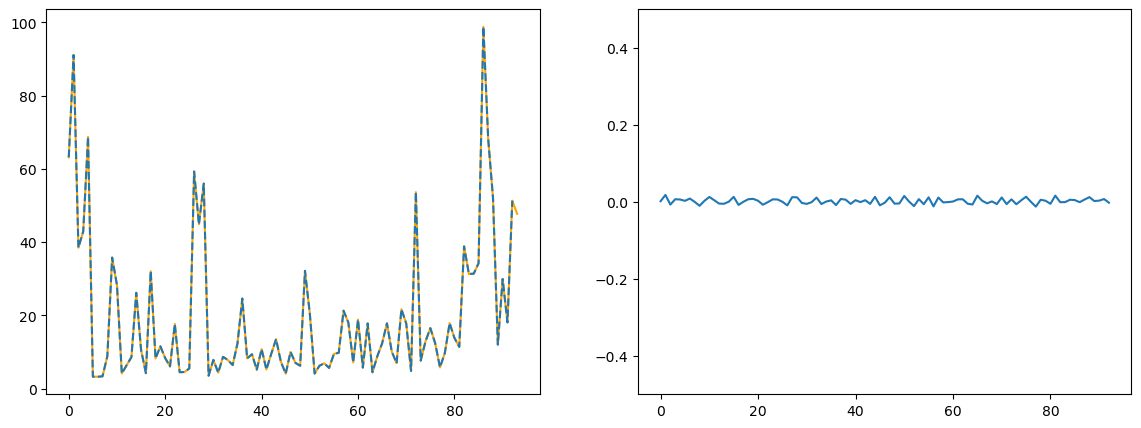

In [102]:
manual_offset = 4
Trial_start_camera_ts_reset = Trial_start_camera_ts[manual_offset::]

fig, [ax,ax1] = plt.subplots(1, 2, figsize=(14, 5))
ax.plot(np.diff(Trial_start_camera_ts_reset), color = 'orange')
ax.plot(np.diff(poke_data.Trial_Start.unique()),'--')
# plt.xlim([260, 290])
# plt.xlim([0, 50])

a = Trial_start_camera_ts_reset[0:len(poke_data.Trial_Start.unique())]
b = poke_data.Trial_Start.unique()

ax1.plot(np.diff(a) - np.diff(b))
ax1.set_ylim([-0.5, 0.5])


trim length and check alingment one final time

(-0.5, 0.5)

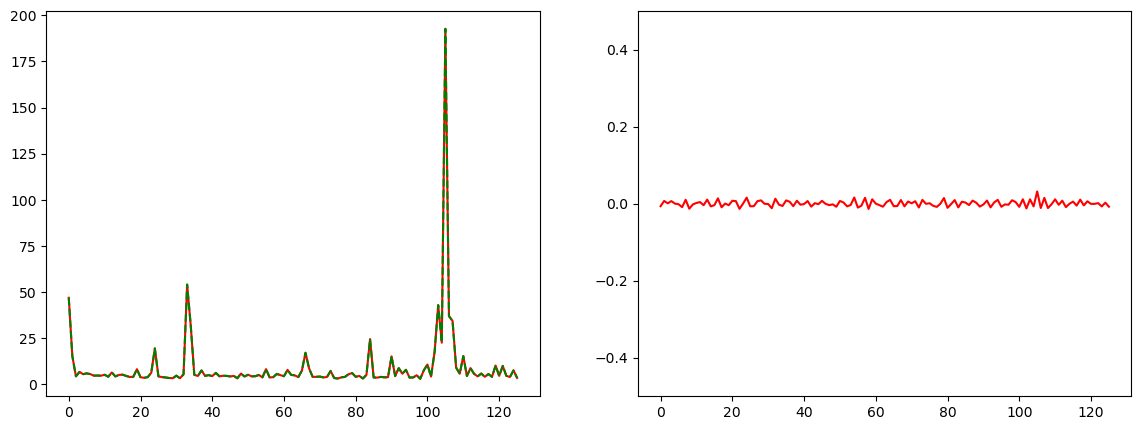

In [62]:
# perform fix: # puts a nan value where it detects ther is a missing trigger

# old fix method - not 100% sure what it actually does...
# fixed = test_timestamps_(trial_start_bpod_ts,Trial_start_camera_ts_reset)
# fixed_Trial_start_camera_ts = fixed[0:len(trial_start_bpod_ts)]


### trim data down to the same length:
trial_start_bpod_ts = poke_data.Trial_Start.unique()
fixed_Trial_start_camera_ts = Trial_start_camera_ts_reset[0:len(poke_data.Trial_Start.unique())]

fig, [ax,ax1] = plt.subplots(1, 2, figsize=(14, 5))
ax.plot(np.diff(fixed_Trial_start_camera_ts),color = 'red')
ax.plot(np.diff(poke_data.Trial_Start.unique()), '--', color = 'green')#

ax1.plot(np.diff(fixed_Trial_start_camera_ts) - np.diff(poke_data.Trial_Start.unique()), color = 'red')
ax1.set_ylim([-.5, 0.5])




check alingment makes sense in terms of start to end time difference

In [103]:
print('start end diffs')
print('for ephys ts:      '+ str((fixed_Trial_start_camera_ts)[-1] - (fixed_Trial_start_camera_ts)[0]))
print('for behav ts:      ' + str(trial_start_bpod_ts[-1] -  trial_start_bpod_ts[0])) 

count = 0
for item in (np.diff(fixed_Trial_start_camera_ts) - np.diff(poke_data.Trial_Start.unique())):
    if not np.isnan(item):
        count = count + item 
print('ofset tot is:   ' + str(count))

start end diffs
for ephys ts:      1152.3391250000004
for behav ts:      1152.2464


ValueError: operands could not be broadcast together with shapes (126,) (93,) 

# align timestamps and make dataframe

In [105]:
### align fixed and checked timestamps:
if not len(poke_data.Trial_id.unique()) == len(fixed_Trial_start_camera_ts):
    print('num trials and trial start TTLs not the same length...this could cause issues')
    
back_aligned_time = align_to_start_ts(poke_data.Trial_id.values,fixed_Trial_start_camera_ts)
back_pokein_times = align_allpokes_to_cam_trialstart(poke_data.Trial_id.values, poke_data.Trial_Start.unique(), poke_data.PokeIn_Time.values,fixed_Trial_start_camera_ts)
back_pokeout_times = align_allpokes_to_cam_trialstart(poke_data.Trial_id.values, poke_data.Trial_Start.unique(), poke_data.PokeOut_Time.values,fixed_Trial_start_camera_ts)


### make a new dataframe:

new_PortIn_df = pd.DataFrame(
    {'Trial_id' : poke_data.Trial_id.values,
     'Trial_Start' : poke_data.Trial_Start.values,
     'Port': poke_data.Port.values,
     'PokeIn_Time': poke_data.PokeIn_Time.values,
     'PokeOut_Time': poke_data.PokeOut_Time.values,
     'Reward_Times': poke_data.Reward_Times.values,
     'Trial_End' : poke_data.Trial_End.values,
     'Port_2-3-4-5_LED_intensities': poke_data['Port 2,3,4,5 LED intensities'].values,
     'Port_1-2-3-4_RewardAmount': poke_data['Port 1,2,3,4 RewardAmount'].values,
     'TrainingLevel': poke_data.TrainingLevel.values,
     
     'TrialStart_EphysTime': poke_data.TrialStart_EphysTime.values,
     'FirstPoke_EphysTime': poke_data.FirstPoke_EphysTime.values,
     'PokeIN_EphysTime': poke_data.PokeIN_EphysTime.values,
     'PokeOUT_EphysTime': poke_data.PokeOUT_EphysTime.values,
    
     'backcam_trialstart_seconds':back_aligned_time,
     'backcam_aligned_pokein_times':back_pokein_times,
     'backcam_aligned_pokeout_times':back_pokeout_times,
     'backcam_trialstart_closest_cameraframes': find_closest_cameraframe_index(behav_cam_ts, back_aligned_time),
     'backcam_pokein_closest_cameraframes': find_closest_cameraframe_index(behav_cam_ts, back_pokein_times),
     'backcam_pokeout_closest_cameraframes': find_closest_cameraframe_index(behav_cam_ts, back_pokeout_times)
    })

num trials and trial start TTLs not the same length...this could cause issues


do the same for the transition dataframe

In [106]:
Port_intimes = new_PortIn_df.PokeIn_Time.values
Port_outtimes = new_PortIn_df.PokeOut_Time.values
Ports = new_PortIn_df.Port.values

#Determine Transition times and types for all events 
out_in_Transition_times, in_in_Transition_times, Transition_types, out_in_transition_reference,in_in_transition_reference = Determine_Transition_Times_and_Types(Port_intimes,Port_outtimes,Ports)

#Split transtion types into first and last ports: 
start_port_ids = Start_End_port_id(Transition_types,0)
end_port_ids = Start_End_port_id(Transition_types,1)

#Align start and end port time
End_Port_in_time = Port_intimes[1::]
Start_Port_in_time = Port_intimes[0:-1]
End_Port_out_time = Port_outtimes[1::]
Start_Port_out_time = Port_outtimes[0:-1]

#Find Port repeat events (double pokes)
Non_Port_repeat = determine_RepeatPort_events(start_port_ids,end_port_ids)

#Determine which transitions are good: less than 1.5s
out_in_Filtered_transitions = filter_transitons_by_latency(out_in_Transition_times, 2)
in_in_Filtered_transitions = filter_transitons_by_latency(in_in_Transition_times, 2)

In [107]:
# make dataframe:
new_Transition_df = pd.DataFrame(
    {'Trial_id' : new_PortIn_df['Trial_id'][0:-1],
    'Transition_type' : Transition_types,
     'Start_Port':start_port_ids, 
     'End_Port':end_port_ids,
     'Start_Poke_in_time': Start_Port_in_time,
     'Start_Poke_out_time': Start_Port_out_time,
     'End_Poke_in_time': End_Port_in_time,
     'End_Poke_out_time': End_Port_out_time,
     'out_in_Latency' : out_in_Transition_times,
     'in_in_Latency': in_in_Transition_times,
     '2s_Time_Filter_out_in': out_in_Filtered_transitions,
     '2s_Time_Filter_in_in': in_in_Filtered_transitions,
     'Port_2-3-4-5_LED_intensities': new_PortIn_df['Port_2-3-4-5_LED_intensities'].values[0:-1],
     'Port_1-2-3-4_RewardAmount': new_PortIn_df['Port_1-2-3-4_RewardAmount'].values[0:-1],
     'Repeat_Filter':Non_Port_repeat,
     
     'TrialStart_EphysTime': new_PortIn_df.TrialStart_EphysTime.values[0:-1],
     'FirstPoke_EphysTime': new_PortIn_df.FirstPoke_EphysTime.values[0:-1],
     'P1_IN_Ephys_TS': new_PortIn_df.PokeIN_EphysTime.values[0:-1],
     'P1_OUT_Ephys_TS': new_PortIn_df.PokeOUT_EphysTime.values[0:-1],
     'P2_IN_Ephys_TS': new_PortIn_df.PokeIN_EphysTime.values[1::],
     'P2_OUT_Ephys_TS': new_PortIn_df.PokeOUT_EphysTime.values[1::],
     
     'backcam_trialstart_seconds':back_aligned_time[0:-1],
     'backcam_aligned_P1In_times':back_pokein_times[0:-1],
     'backcam_aligned_P1Out_times':back_pokeout_times[0:-1],
     'backcam_aligned_P2In_times':back_pokein_times[1::],
     'backcam_aligned_P2Out_times':back_pokeout_times[1::],
     
     'backcam_trialstart_closest_cameraframes': find_closest_cameraframe_index(behav_cam_ts, back_aligned_time)[0:-1],
     'backcam_P1In_closest_cameraframes': find_closest_cameraframe_index(behav_cam_ts, back_pokein_times)[0:-1],
     'backcam_P1Out_closest_cameraframes': find_closest_cameraframe_index(behav_cam_ts, back_pokeout_times)[0:-1],
     'backcam_P2In_closest_cameraframes': find_closest_cameraframe_index(behav_cam_ts, back_pokein_times)[1::],
     'backcam_P2Out_closest_cameraframes': find_closest_cameraframe_index(behav_cam_ts, back_pokeout_times)[1::],
     
    
    })

## run alignment checks! 

In [108]:
# tracking 
# behav_path = '\\'.join(list(Path(organised_ephys_path).parts[0:-1])) + r'\video\tracking\2_task\\'
behav_path = '\\'.join(list(Path(organised_ephys_path).parts[0:-1])) + r'\video\tracking\\'


# load in tracking data 
for t_file in os.listdir(behav_path):
    if '.h5' in t_file:
        print(t_file)
        tracking_file = behav_path+t_file
        if 'PORTS' in t_file:
            ports = load_H5_bodypart_ports(tracking_file)
            p1_all,p2_all,p3_all,p4_all,p5_all = ports[0::]
        elif 'BACK' in t_file:
            back_head_centre_all = load_H5_bodypart_ports(tracking_file)[0]
            
task_epoch_start = np.where(cam_ts.epoch == 'task')[0][0]
task_epoch_end = np.where(cam_ts.epoch == 'task')[0][-1]

print(len(cam_ts))
print(len(back_head_centre_all))
print(len(p1_all))

## trim down to task relevant part
back_head_centre = back_head_centre_all[task_epoch_start:task_epoch_end]
p1 = p1_all[task_epoch_start:task_epoch_end]
p2 = p2_all[task_epoch_start:task_epoch_end]
p3 = p3_all[task_epoch_start:task_epoch_end]
p4 = p4_all[task_epoch_start:task_epoch_end]
p5 = p5_all[task_epoch_start:task_epoch_end]


ABOVE_CAM_AP5_2_R_16-11-2024DLC_resnet50_ABOVE_generalDec4shuffle1_650000.h5
BACK_CAM_AP5_2_R_16-11-2024DLC_resnet50_BACK_ap5_rigDec4shuffle1_720000.h5
BACK_CAM_AP5_2_R_16-11-2024DLC_resnet50_BACK_PORTS_hpc_rigDec4shuffle1_640000.h5
828201
828202
828202


red - port 1
green - port 6
blue - port 3


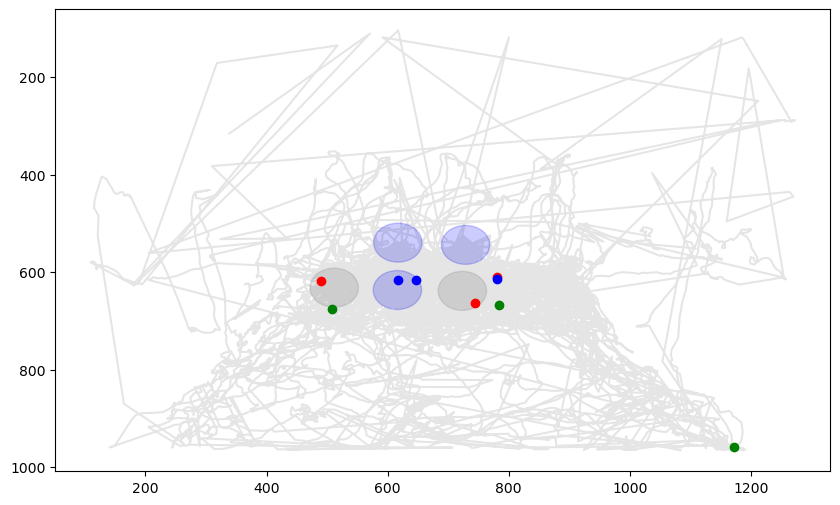

In [109]:
port_centroids = [(np.median(p1.x),np.median(p1.y)),(np.median(p2.x),np.median(p2.y)),(np.median(p3.x),np.median(p3.y)),(np.median(p4.x),np.median(p4.y)),(np.median(p5.x),np.median(p5.y))]

fig, ax = plt.subplots(1, 1,figsize=(10, 6))
for index,port_centroid in enumerate(port_centroids):
    ## define rings around important ports: port 5, port2, port 3, port4
    radius = 40
    ax.plot(port_centroid[0],port_centroid[1],'o',alpha = 0)
    c = ['blue','grey','blue','grey','blue']
    circle = plt.Circle(port_centroid, radius, color=c[index], alpha = 0.2)
    ax.add_patch(circle)
ax.invert_yaxis()

start_ = 0
end_ = -1
x_ = back_head_centre.interped_x.values
y_ = back_head_centre.interped_y.values

ax.plot(x_[start_:end_],y_[start_:end_], '-',color = 'black', alpha = 0.1)

port1_inds = [np.where(new_PortIn_df.Port.values == 1)[0][10], np.where(new_PortIn_df.Port.values == 1)[0][int(new_PortIn_df.Trial_id.values[-1]/2)], np.where(new_PortIn_df.Port.values == 1)[0][-10]]
port3_inds = [np.where(new_PortIn_df.Port.values == 3)[0][10], np.where(new_PortIn_df.Port.values == 3)[0][int(new_PortIn_df.Trial_id.values[-1]/2)], np.where(new_PortIn_df.Port.values == 3)[0][-5]]
port6_inds = [np.where(new_PortIn_df.Port.values == 6)[0][10], np.where(new_PortIn_df.Port.values == 6)[0][int(new_PortIn_df.Trial_id.values[-1]/2)], np.where(new_PortIn_df.Port.values == 6)[0][-5]]

closest_inds1= []
for ind in port1_inds:
    current_poke_in_time = back_pokein_times[ind]
    # find the ind where the camera timestamp is closest to the poke in time
    closest_inds1 += [np.argmin(np.abs(behav_cam_ts['Time Stamps'].values - current_poke_in_time))]
for ind in closest_inds1:
    ax.plot(x_[ind],y_[ind],'o', color = 'red')
    
closest_inds6= []
for ind in port6_inds:
    current_poke_in_time = back_pokein_times[ind]
    # find the ind where the camera timestamp is closest to the poke in time
    closest_inds6 += [np.argmin(np.abs(behav_cam_ts['Time Stamps'].values - current_poke_in_time))]
for ind in closest_inds6:
    ax.plot(x_[ind],y_[ind],'o', color = 'green')
    
closest_inds3= []
for ind in port3_inds:
    current_poke_in_time = back_pokein_times[ind]
    # find the ind where the camera timestamp is closest to the poke in time
    closest_inds3 += [np.argmin(np.abs(behav_cam_ts['Time Stamps'].values - current_poke_in_time))]
for ind in closest_inds3:
    ax.plot(x_[ind],y_[ind],'o', color = 'blue')
    
print('red - port 1')
print('green - port 6') 
print('blue - port 3') 


make test videos 

In [76]:
avi_files = [f for f in os.listdir(behav_path) if f.endswith('.avi')]
cam_path = behav_path+avi_files[0]

IndexError: list index out of range

In [77]:
avi_files

[]

In [395]:

# Specify the directory
dir_path = r'D:\\camera_test\\'
# Get a list of all files in the directory
files = glob.glob(os.path.join(dir_path, '*'))
# Loop through the files and delete each one
for file in files:
    os.remove(file)
print("All files deleted in the directory:", dir_path)

## create test videos 
# avi_files = [f for f in os.listdir(behav_path) if f.endswith('.avi')]
# cam_path = behav_path+avi_files[0]
cam_path = r'Z:\\projects\\sequence_squad\\revision_data\\lars_recordings\\video\\\\seq006\\seq006__20241118\\seq006__20241118__camera_22024-11-18T13_11_58.avi'


for ind in closest_inds1:
    camera_frame = ind + behav_cam_ts.index[0]
    start_frame_number = camera_frame-20
    end_frame_number = camera_frame	
    output_video_path = dir_path +'port3_'+str(ind) + '_back_test.mp4'
    extract_frames_by_number(cam_path, output_video_path, start_frame_number, end_frame_number)



All files deleted in the directory: D:\\camera_test\\
Extracted video saved to D:\\camera_test\\port3_19408_back_test.mp4
Extracted video saved to D:\\camera_test\\port3_47968_back_test.mp4
Extracted video saved to D:\\camera_test\\port3_118679_back_test.mp4


# SAVE OUT THE DATAFRAMES

In [82]:
#if alignment is good then save out the data:

out_path = '\\'.join(list(Path(organised_ephys_path).parts[0:-1]))
out_path = out_path + r'\behav_sync\\2_task\\'
print(out_path)

new_PortIn_df.to_csv(out_path +'Behav_Ephys_Camera_Sync.csv')

new_Transition_df.to_csv(out_path +'Transition_data_sync.csv')


print('data checked?')
print('data Saved')

Z:\\projects\sequence_squad\revision_data\organised_data\animals\seq006_implant1\recording3_18-11-2024\behav_sync\\2_task\\
data checked?
data Saved


# PRE/POSTSLEEP

# testing area

In [ ]:


port3_inds = [np.where(new_PortIn_df.Port.values == 3)[0][10], np.where(new_PortIn_df.Port.values == 3)[0][int(new_PortIn_df.Trial_id.values[-1]/2)], np.where(new_PortIn_df.Port.values == 3)[0][-5]]
port1_inds = [np.where(new_PortIn_df.Port.values == 1)[0][10], np.where(new_PortIn_df.Port.values == 1)[0][int(new_PortIn_df.Trial_id.values[-1]/2)], np.where(new_PortIn_df.Port.values == 1)[0][-10]]


# Specify the directory
dir_path = r'D:\\camera_test\\'
# Get a list of all files in the directory
files = glob.glob(os.path.join(dir_path, '*'))
# Loop through the files and delete each one
for file in files:
    os.remove(file)
print("All files deleted in the directory:", dir_path)

## create test videos 
avi_files = [f for f in os.listdir(behav_path) if f.endswith('.avi')]
cam_path = behav_path+avi_files[0]

for ind in port1_inds:
    frame_time = back_pokein_times[ind]
    ffmpeg_extract_subclip(cam_path,frame_time - 1,frame_time,targetname=(dir_path +'port1_'+str(ind) + '_back_test.mp4'))
    
for ind in port3_inds:
    frame_time = back_pokein_times[ind]
    ffmpeg_extract_subclip(cam_path,frame_time-1,frame_time,targetname=(dir_path +'port3_'+str(ind) + '_back_test.mp4'))